In [1]:
import pandas as pd
from typing import List, Tuple
import numpy as np

In [2]:
import pandas as pd
from typing import List, Tuple
import numpy as np

def downsample_timeseries_data(df: pd.DataFrame, 
                            context_windows: List[str], 
                            call_window: str, 
                            response_window: str,
                            call_feature_index: List[int],
                            context_feature_index: List[List[int]],
                            response_feature_index: List[int]) -> dict:
    """
    Process a timeseries DataFrame based on user-defined parameters.

    Args:
    df (pd.DataFrame): The original DataFrame with a DateTimeIndex.
    time_windows (List[str]): List of time windows for downsampling (e.g., ['1H', '2D', '3W']).
    context_sizes (List[int]): List of context sizes corresponding to each time window.
    call_sizes (List[int]): List of call sizes for constructing lookback blocks.
    response_size (int): Size of the response block.

    Returns:
    dict: A dictionary containing the downsampled timeseries for each time window. 
    """
    processed_data = {}

    # Function to downsample the DataFrame
    def downsample(df, window):
        """
        Downsample the DataFrame, taking the mean of each window and setting the 
        index to the maximum timestamp in that window.
        """
        # First, calculate the mean for each window
        mean_df = df.resample(window).mean()

        # Then, find the maximum timestamp in each window
        max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())

        # Set the maximum timestamps as the new index
        mean_df.index = max_timestamps.values

        return mean_df

    processed_data['call'] = downsample(df.iloc[:,call_feature_index], call_window)
    processed_data['response'] = downsample(df.iloc[:,response_feature_index], response_window)
    
    contexts = []
    for i, context_window in enumerate(context_windows):
        contexts.append(downsample(df.iloc[:,context_feature_index[i]], context_window))
        
    processed_data['contexts'] = contexts
    return processed_data

def slice_timeseries_data(downsampled_data: pd.DataFrame, 
                            sizes: dict,
                            thresholds: dict) -> np.array:
    
    def get_max_timestamp_less_than(timestamp, df_sel):
    # Find the maximum timestamp less than the given timestamp
        filtered_timestamps = df_sel.index[df_sel.index < timestamp]
        return filtered_timestamps.max() if not filtered_timestamps.empty else None

    def get_preceding_timestamps(timestamp, df_sel, slice_size):
        """
        Retrieve a specified number of timestamps preceding (and excluding) the given timestamp.
        """
        # Find the maximum timestamp less than the given timestamp
        max_less_than_timestamp = get_max_timestamp_less_than(timestamp, df_sel)
        if max_less_than_timestamp is None:
            return pd.DataFrame()  # Return empty DataFrame if no suitable timestamp is found

        # Find the index of this timestamp in df_sel
        closest_idx = df_sel.index.searchsorted(timestamp, side='left')

        # Extract the preceding timestamps
        start_idx = max(closest_idx - slice_size, 0)
        relevant_timestamps = df_sel.iloc[start_idx:closest_idx, :]
        
        return relevant_timestamps  
    
    def get_following_timestamps(timestamp, df_sel, slice_size):
        """
        Retrieve timestamps equal to or greater than the selected timestamp.
        """
        # Find the index of the closest timestamp in df_sel
        closest_idx = df_sel.index.searchsorted(timestamp, side='left')
        
        # Ensure index is within bounds
        if closest_idx >= len(df_sel):
            return pd.DataFrame()  # Return empty DataFrame if index is out of bounds

        # Extract the following timestamps
        end_idx = min(closest_idx + slice_size, len(df_sel))
        relevant_timestamps = df_sel.iloc[closest_idx:end_idx, :]
        
        return relevant_timestamps
    
    def fill_numpy(relevant_timestamps,slice_size, direction):
        # Create a placeholder array
        placeholder_array = np.zeros([slice_size, relevant_timestamps.shape[1]])
        
        # Fill the placeholder array from the bottom
        if direction == "preceding":
            placeholder_array[-len(relevant_timestamps):] = relevant_timestamps.to_numpy()
        else:
            placeholder_array[:len(relevant_timestamps)] = relevant_timestamps.to_numpy()
        
        return placeholder_array
    
    context_sizes = [sizes[key] for key in sizes if 'context' in key]
    sliced_data = {f'context_{i}': [] for i in range(len(context_sizes))}
    sliced_data['call'] = []
    sliced_data['response'] = []
    
    selected_timestamps = []
    # Loop through each timestamp in your downsampled_data
    for timestamp in downsampled_data['response'].index:
        # Check if we have enough, call, context, and response data. 
        check_size_dict = {f'context_{i}': get_preceding_timestamps(timestamp, downsampled_data['contexts'][i], sizes[f'context_{i}']) for i in range(len(context_sizes))}
        check_size_dict['call'] = get_preceding_timestamps(timestamp, downsampled_data['call'], sizes['call'])
        check_size_dict['response'] = get_following_timestamps(timestamp, downsampled_data['response'], sizes['response'])
        
        size_check = []
        for key, value in check_size_dict.items():
            size_check.append((value.shape[0] / sizes[key]) >= thresholds[key])

        if size_check.count(False)==0:
            # Add timestamp to list
            selected_timestamps.append(timestamp)
    
            for key in check_size_dict:
                if key == 'forward':
                    direction = 'following'
                else:
                    direction = 'preceding'
                # Append the result of get_preceding_timestamps to the list in the dictionary
                sliced_data[key].append(fill_numpy(check_size_dict[key], sizes[key], direction))
            
    # After the loop, use np.vstack to combine the arrays for each key
    stacked_arrays_dict = {key: np.stack(value) for key, value in sliced_data.items()}
    
    return stacked_arrays_dict, selected_timestamps

def masked_expand(sliced_data, sizes):
    sizes['response']
    
    expanded_dict = {}
    for key, value in sliced_data.items():
        if key == "response":
            res_shape = value.shape
            response_data = value.reshape(res_shape[0]*res_shape[1],res_shape[2])
            mask_array = np.tile(np.repeat(np.tril(np.ones([res_shape[1],res_shape[1]]),-1)[:,:,np.newaxis], res_shape[2], axis=2), (res_shape[0], 1, 1))
            expanded_dict[key] = np.repeat(value,sizes['response'],axis=0) * mask_array
        else:
            expanded_dict[key] = np.repeat(value,sizes['response'],axis=0)
            
    unmasked_response = np.repeat(sliced_data['response'],sizes['response'],axis=0)
            
    return expanded_dict, response_data, unmasked_response

def create_min_max_df(df):
    """Create a DataFrame with min and max values for each feature."""
    min_values = df.min()
    max_values = df.max()
    min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
    return min_max_df

def scale_data(df, min_max_df, feature_range=(0, 1)):
    """Scale data in df based on min-max values and a given feature range."""
    min_scale, max_scale = feature_range
    scaled_df = pd.DataFrame()

    for column in df.columns:
        min_val = min_max_df.loc[column, 'min']
        max_val = min_max_df.loc[column, 'max']
        # Avoid division by zero in case of constant columns
        if max_val != min_val:
            scaled_df[column] = (df[column] - min_val) / (max_val - min_val) * (max_scale - min_scale) + min_scale
        else:
            scaled_df[column] = df[column]

    return scaled_df

In [3]:
# Example usage:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]
context_windows = ['1H', '2H', '6H']
context_sizes = [24, 12, 6]
call_window = '10T'
call_size = 24
response_window = '10T'
response_size = 8
call_feature_index = range(0,14)
context_feature_index = [range(0,14),
                        range(0,14),
                        range(0,14)]
response_feature_index = [0, 1, 4]
thresholds = {
    'call': 0.7,
    'response': 0.7,
    'context_0': 0.7,
    'context_1': 0.7,
    'context_2': 0.7
}
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

In [4]:
#Scale Data
min_max_df = create_min_max_df(df)
print(min_max_df)
scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

                     min      max
p (mbar)          944.58  1005.71
T (degC)          -23.01     7.64
Tpot (K)          250.60   283.19
Tdew (degC)       -25.01     2.51
rh (%)             42.38   100.00
VPmax (mbar)        0.95    10.48
VPact (mbar)        0.79     7.32
VPdef (mbar)        0.00     4.94
sh (g/kg)           0.50     4.80
H2OC (mmol/mol)     0.80     7.69
rho (g/m**3)     1179.43  1383.38
wv (m/s)            0.00     9.71
max. wv (m/s)       0.00    14.50
wd (deg)            0.00   358.90


In [5]:
downsampled_data = downsample_timeseries_data(scaled_df, 
                                        context_windows, 
                                        call_window, 
                                        response_window,
                                        call_feature_index,
                                        context_feature_index,
                                        response_feature_index)
downsampled_data

{'call':                      p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
 2009-01-01 00:10:00  0.849665  0.489070  0.454127     0.585392  0.883721   
 2009-01-01 00:20:00  0.850483  0.476346  0.442160     0.571584  0.885456   
 2009-01-01 00:30:00  0.849828  0.473083  0.439092     0.570494  0.894134   
 2009-01-01 00:40:00  0.849501  0.479608  0.445535     0.579215  0.899341   
 2009-01-01 00:50:00  0.849501  0.480914  0.446456     0.580305  0.897605   
 ...                       ...       ...       ...          ...       ...   
 2009-02-04 16:40:00  0.435302  0.821207  0.829396     0.897892  0.717112   
 2009-02-04 16:50:00  0.435302  0.813703  0.822031     0.898256  0.743145   
 2009-02-04 17:00:00  0.435793  0.813703  0.822031     0.901163  0.751822   
 2009-02-04 17:10:00  0.438737  0.811746  0.820190     0.900073  0.753558   
 2009-02-04 17:20:00  0.442827  0.815661  0.822952     0.904070  0.753558   
 
                      VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh

In [6]:
sliced_data, selected_timestamps = slice_timeseries_data(downsampled_data,
                                    sizes,
                                    thresholds)

sliced_data

{'context_0': array([[[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
          0.10356322, 0.40466704],
         [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
          0.13390805, 0.91028142],
         [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
          0.06045977, 0.61177673],
         ...,
         [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
          0.07195402, 0.51109873],
         [0.87602923, 0.59624796, 0.55139613, ..., 0.07621009,
          0.08632184, 0.48611498],
         [0.87551121, 0.59510604, 0.55037333, ..., 0.07020254,
          0.08494253, 0.57341414]],
 
        [[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
          0.10356322, 0.40466704],
         [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
          0.13390805, 0.91028142],
         [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
          0.06045977, 0.61177673],
         ...,
         [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
          0

In [7]:
for key in sliced_data:
    print(sliced_data[key].shape)

(4816, 24, 14)
(4816, 12, 14)
(4816, 6, 14)
(4816, 24, 14)
(4816, 8, 3)


In [8]:
sliced_data['response']

array([[[0.87387535, 0.60619902, 0.93405068],
        [0.87567479, 0.60783034, 0.92884415],
        [0.87632913, 0.60978793, 0.92884415],
        ...,
        [0.87698348, 0.61174551, 0.92016661],
        [0.87665631, 0.61109299, 0.92190212],
        [0.87698348, 0.6091354 , 0.9184311 ]],

       [[0.87567479, 0.60783034, 0.92884415],
        [0.87632913, 0.60978793, 0.92884415],
        [0.87731065, 0.61207178, 0.92710864],
        ...,
        [0.87665631, 0.61109299, 0.92190212],
        [0.87698348, 0.6091354 , 0.9184311 ],
        [0.87714706, 0.60815661, 0.91669559]],

       [[0.87632913, 0.60978793, 0.92884415],
        [0.87731065, 0.61207178, 0.92710864],
        [0.87747424, 0.61500816, 0.92363763],
        ...,
        [0.87698348, 0.6091354 , 0.9184311 ],
        [0.87714706, 0.60815661, 0.91669559],
        [0.87747424, 0.60946166, 0.91669559]],

       ...,

       [[0.4331752 , 0.86362153, 0.63901423],
        [0.43513823, 0.84730832, 0.66331135],
        [0.43530182, 0

In [9]:
expanded_dict, response_data, unmasked_response = masked_expand(sliced_data, sizes)

print(response_data[0,:])
for ir in range(30):
    print(expanded_dict['response'][ir,:,:])
    
for key in expanded_dict:
    print(expanded_dict[key].shape)
    
print(response_data.shape)

[0.87387535 0.60619902 0.93405068]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.87387535 0.60619902 0.93405068]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.60619902 0.93405068]
 [0.87567479 0.60783034 0.92884415]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.60619902 0.93405068]
 [0.87567479 0.60783034 0.92884415]
 [0.87632913 0.60978793 0.92884415]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

In [10]:
print(expanded_dict['response'])

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.87387535 0.60619902 0.93405068]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.87387535 0.60619902 0.93405068]
  [0.87567479 0.60783034 0.92884415]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.43530182 0.83425775 0.68934398]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def ksize(size):
    return max([2, round(size / 9)])

class FormHead(nn.Module):
    def __init__(self, size, feature_len, csize=64, channels=1):
        super(FormHead, self).__init__()
        self.conv = nn.Conv2d(channels, csize, kernel_size=(ksize(size), ksize(feature_len)))
        self.pool = nn.MaxPool2d(2, 2)
        # Placeholder for the linear layer
        self.fc = None

    def forward(self, x):
        x = F.leaky_relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        if self.fc is None:
            # Dynamically compute the input size for the linear layer
            size = x.size(1)
            self.fc = nn.Linear(size, 64)
        x = F.leaky_relu(self.fc(x))
        return x

class Cerberus(nn.Module):
    def __init__(self, training_data, response_data, csize=64):
        super(Cerberus, self).__init__()
        train_call = training_data['call']
        train_contexts = [training_data[key] for key in training_data if 'context' in key]
        train_response = training_data['response']

        context_dims = [cont.shape for cont in train_contexts]
        call_size, call_fl = train_call.shape[1], train_call.shape[2]
        res_size, res_fl = train_response.shape[1], train_response.shape[2]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[1], icl[2], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)

        self.fc1 = nn.Linear(csize * (2 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
        self.fc3 = nn.Linear(csize * 8 + train_call.shape[2], csize * 4)
        self.fc4 = nn.Linear(csize * 4, csize)
        self.fc5 = nn.Linear(csize, csize // 2)
        self.out = nn.Linear(csize // 2, response_data.shape[1])

    def forward(self, x_call, x_contexts, x_response):
        call_head_out = self.call_head(x_call)
        last_known = x_call[:,0,-1,:]
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out], dim=1)
        # print(necks.shape)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        body = F.leaky_relu(self.fc3(torch.cat([necks] + [last_known], dim=1)))
        body = F.leaky_relu(self.fc4(body))
        body = F.leaky_relu(self.fc5(body))
        body = self.out(body)
        return body

In [33]:
class Foresight(nn.Module):
    def __init__(self, training_data, csize=64):
        super(Foresight, self).__init__()
        train_call = training_data['call']
        train_contexts = [training_data[key] for key in training_data if 'context' in key]
        train_response = training_data['response']

        context_dims = [cont.shape for cont in train_contexts]
        call_size, call_fl = train_call.shape[1], train_call.shape[2]
        res_size, res_fl = train_response.shape[1], train_response.shape[2]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[1], icl[2], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)

        self.fc1 = nn.Linear(csize * (2 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
    
        # Parameters for reshaping the output of the linear layer
        self.reshape_channels = csize * 8  # Number of channels after reshaping
        self.reshape_height = train_response.shape[1]      # Height after reshaping
        self.reshape_width = train_response.shape[2]     # Width after reshaping

        self.expander = nn.Linear(csize * 8, self.reshape_channels * self.reshape_height * self.reshape_width)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(csize * 8, csize * 16, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(csize * 16, 2, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               output_padding=0),
        )

    def forward(self, x_call, x_contexts, x_response):
        call_head_out = self.call_head(x_call)
        last_known = x_call[:,0,-1,:]
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out], dim=1)
        # print(necks.shape)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        necks = F.leaky_relu(self.expander(necks))
        necks = necks.view(-1, self.reshape_channels, self.reshape_height, self.reshape_width)
        out = self.decoder(necks)
        return out

In [34]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super(GaussianNLLLoss, self).__init__()

    def forward(self, output, observed):
        """
        output: Tensor of shape [batch_size, 2, timesteps, features]
                - output[:, 0, :, :] is the predicted mean
                - output[:, 1, :, :] is the predicted log variance (for numerical stability)

        observed: Tensor of shape [batch_size, 1, timesteps, features]
        """
        # Separate the mean and variance
        mean = output[:, 0, :, :]
        log_variance = output[:, 1, :, :]  # Log variance for numerical stability

        # Calculate the Gaussian negative log likelihood
        nll = 0.5 * torch.exp(-log_variance) * (observed - mean) ** 2 + 0.5 * log_variance
        return nll.mean()

# Example usage
criterion = GaussianNLLLoss()
output = torch.randn(100, 2, 8, 3)  # Example output
observed = torch.randn(100, 1, 8, 3)  # Example observed data

loss = criterion(output, observed)
print(loss)

tensor(1.5893)


In [35]:
from torch.utils.data import DataLoader, TensorDataset
import random

num_epochs = 30

foresight = Foresight(expanded_dict)

# Define a loss function and optimizer
criterion = GaussianNLLLoss()
optimizer = torch.optim.Adam(foresight.parameters(), lr=0.001)

train_len = 200
train_index = random.sample(range(train_len),train_len)
calls = torch.tensor(expanded_dict['call'][train_index,:,:], dtype=torch.float32).unsqueeze(1)
contexts = [torch.tensor(expanded_dict[key][train_index,:,:], dtype=torch.float32).unsqueeze(1) for key in expanded_dict if 'context' in key]
responses = torch.tensor(expanded_dict['response'][train_index,:,:], dtype=torch.float32).unsqueeze(1)
unmasked = torch.tensor(unmasked_response[train_index,:,:], dtype=torch.float32).unsqueeze(1)
y = torch.tensor(response_data[train_index,:], dtype=torch.float32)

batch_size = 100
# Training loop
for epoch in range(num_epochs):
    foresight.train()
    running_loss = 0.0
    for i in range(0, len(calls), batch_size):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = foresight(calls[i:i+batch_size], [cont[i:i+batch_size] for cont in contexts], responses[i:i+batch_size])
        loss = criterion(outputs, unmasked[i:i+batch_size])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")

Epoch [1/30], Loss: 49.19455474615097
Epoch [2/30], Loss: 3.6337666511535645
Epoch [3/30], Loss: 4.7205119132995605
Epoch [4/30], Loss: 3.699834704399109
Epoch [5/30], Loss: 1.96785306930542
Epoch [6/30], Loss: 0.962662935256958
Epoch [7/30], Loss: 1.0336460769176483
Epoch [8/30], Loss: 0.6787325739860535
Epoch [9/30], Loss: 0.6378073692321777
Epoch [10/30], Loss: 0.260502140969038
Epoch [11/30], Loss: -0.639829158782959
Epoch [12/30], Loss: -1.637436866760254
Epoch [13/30], Loss: 3.377904951572418
Epoch [14/30], Loss: -0.5522380620241165
Epoch [15/30], Loss: 0.0674152197316289
Epoch [16/30], Loss: 0.31505538523197174
Epoch [17/30], Loss: 0.4347781091928482
Epoch [18/30], Loss: 0.4904810041189194
Epoch [19/30], Loss: 0.5076849162578583
Epoch [20/30], Loss: 0.5024681389331818
Epoch [21/30], Loss: 0.4829871505498886
Epoch [22/30], Loss: 0.45331592857837677
Epoch [23/30], Loss: 0.41513417661190033
Epoch [24/30], Loss: 0.368584081530571
Epoch [25/30], Loss: 0.31263525784015656
Epoch [26/30

In [36]:
# Set the model to evaluation mode
foresight.eval()

# Run the model forward pass
with torch.no_grad():  # No need to compute gradients during inference
    predictions = foresight(calls, contexts, responses)
predictions = predictions.numpy()

In [37]:
print(expanded_dict['response'].shape)
selval = 500
selected_data = {key: value[selval:(selval+1),:] for key, value in expanded_dict.items()}
selected_response = unmasked_response[selval:(selval+1),:,:]
calls = torch.tensor(selected_data['call'], dtype=torch.float32).unsqueeze(1)
contexts = [torch.tensor(selected_data[key], dtype=torch.float32).unsqueeze(1) for key in selected_data if 'context' in key]
#responses = torch.tensor(np.zeros([1,selected_data['response'].shape[1],selected_data['response'].shape[2]]), dtype=torch.float32).unsqueeze(1)
responses = torch.tensor(selected_data['response'], dtype=torch.float32).unsqueeze(1)
print(responses)
print(selected_response)

with torch.no_grad():
    predictions = foresight(calls, contexts, responses)
predictions = predictions.numpy()


(38528, 8, 3)
tensor([[[[0.9033, 0.6584, 0.8160],
          [0.9053, 0.6581, 0.7987],
          [0.9087, 0.6584, 0.7969],
          [0.9092, 0.6581, 0.8022],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
[[[0.90332079 0.65840131 0.8160361 ]
  [0.90528382 0.65807504 0.79868101]
  [0.90871912 0.65840131 0.79694551]
  [0.90920988 0.65807504 0.80215203]
  [0.91002781 0.65676998 0.80909406]
  [0.91035498 0.65415987 0.81777161]
  [0.91231801 0.65415987 0.82644915]
  [0.9136267  0.65383361 0.83165568]]]


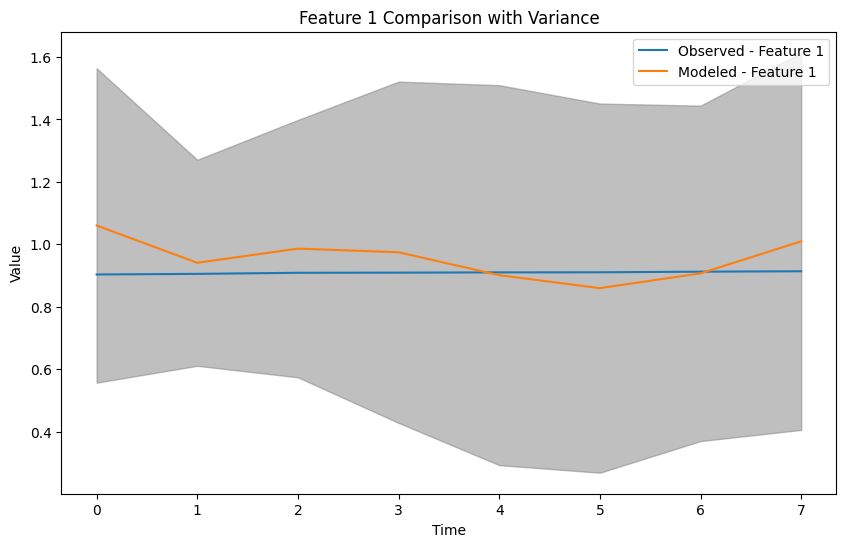

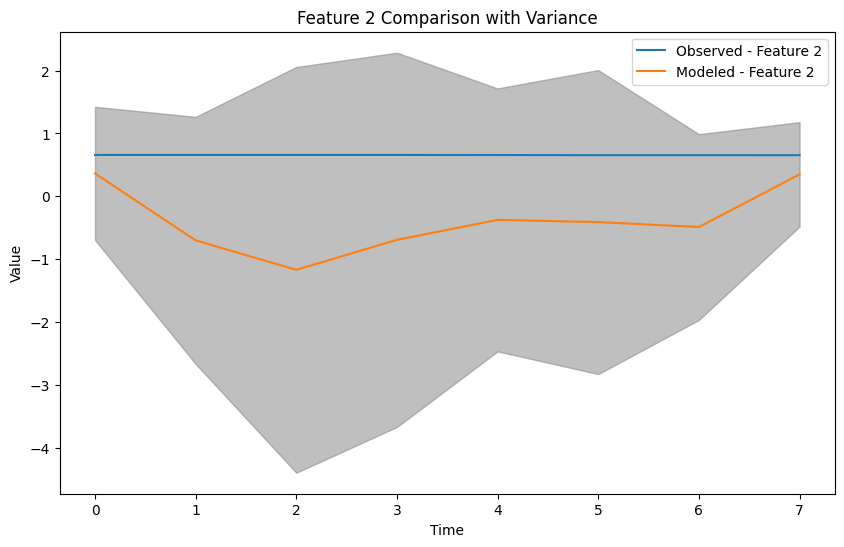

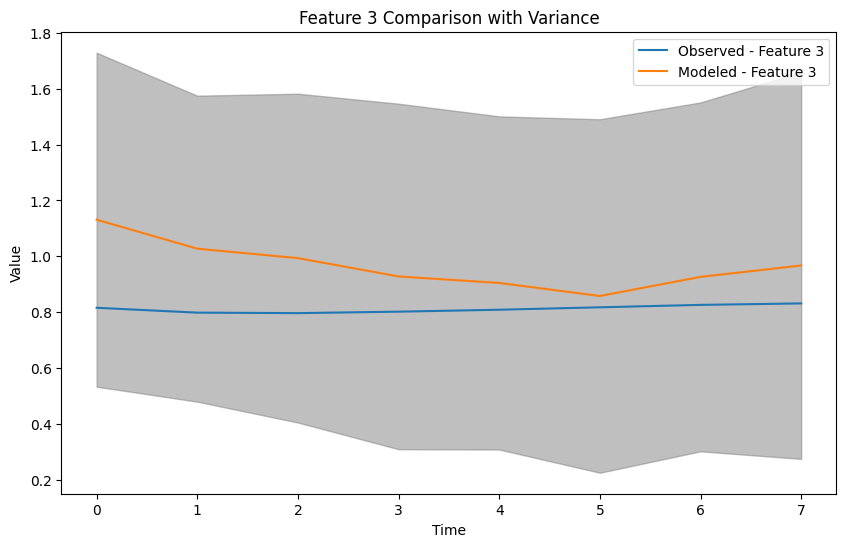

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_response[0,:,:]
modeled_mean = predictions[0,0,:,:]
log_modeled_variance = predictions[0,1,:,:]

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    
    # Plot observed data
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    
    # Plot modeled data (mean)
    plt.plot(modeled_mean[:, i], label='Modeled - Feature {}'.format(i+1))
    
    # Calculate standard deviation from log variance
    std_dev = np.exp(log_modeled_variance[:, i] / 2)
    
    # Create ribbon plot for variance
    plt.fill_between(range(num_rows), 
                     modeled_mean[:, i] - std_dev, 
                     modeled_mean[:, i] + std_dev, 
                     color='gray', alpha=0.5)

    # Plot settings
    plt.title(f'Feature {i+1} Comparison with Variance')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [39]:
# Freeze all foresight weights
for param in foresight.parameters():
    param.requires_grad = False

In [47]:
class CerberusForesight(nn.Module):
    def __init__(self, training_data, response_data, foresight, csize=64):
        super(CerberusForesight, self).__init__()
        # Load in foresight model
        self.foresight = foresight
        
        train_call = training_data['call']
        train_contexts = [training_data[key] for key in training_data if 'context' in key]
        train_response = training_data['response']

        context_dims = [cont.shape for cont in train_contexts]
        call_size, call_fl = train_call.shape[1], train_call.shape[2]
        res_size, res_fl = train_response.shape[1], train_response.shape[2]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[1], icl[2], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)
        
        self.foresight_head = FormHead(res_size, res_fl, csize, channels=2)

        self.fc1 = nn.Linear(csize * (3 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
        self.fc3 = nn.Linear(csize * 8 + train_call.shape[2], csize * 4)
        self.fc4 = nn.Linear(csize * 4, csize)
        self.fc5 = nn.Linear(csize, csize // 2)
        self.out = nn.Linear(csize // 2, response_data.shape[1])

    def forward(self, x_call, x_contexts, x_response):
        
        # Produce foresight
        foresight_out = self.foresight(x_call, x_contexts, x_response)
        print(foresight_out.shape)
        foresight_head_out = self.foresight_head(foresight_out)
        print(foresight_head_out.shape)
        
        call_head_out = self.call_head(x_call)
        print(call_head_out.shape)
        last_known = x_call[:,0,-1,:]
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out] + [foresight_head_out], dim=1)
        # print(necks.shape)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        body = F.leaky_relu(self.fc3(torch.cat([necks] + [last_known], dim=1)))
        body = F.leaky_relu(self.fc4(body))
        body = F.leaky_relu(self.fc5(body))
        body = self.out(body)
        return body

In [48]:
from torch.utils.data import DataLoader, TensorDataset
import random

num_epochs = 30

#model = Cerberus(expanded_dict, response_data)
model = CerberusForesight(expanded_dict, response_data, foresight)

# Define a loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_len = 20000
train_index = random.sample(range(train_len),train_len)
calls = torch.tensor(expanded_dict['call'][train_index,:,:], dtype=torch.float32).unsqueeze(1)
contexts = [torch.tensor(expanded_dict[key][train_index,:,:], dtype=torch.float32).unsqueeze(1) for key in expanded_dict if 'context' in key]
responses = torch.tensor(expanded_dict['response'][train_index,:,:], dtype=torch.float32).unsqueeze(1)

y = torch.tensor(response_data[train_index,:], dtype=torch.float32)
batch_size = 100
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(calls), batch_size):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(calls[i:i+batch_size], [cont[i:i+batch_size] for cont in contexts], responses[i:i+batch_size])
        loss = criterion(outputs, y[i:i+batch_size])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")


torch.Size([100, 2, 8, 3])
torch.Size([100, 64])
torch.Size([100, 64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x384 and 320x1024)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Run the model forward pass
with torch.no_grad():  # No need to compute gradients during inference
    predictions = model(calls, contexts, responses)
predictions = predictions.numpy()

print(predictions)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions)
plt.plot(y.numpy())


In [ ]:
plt.plot(predictions)

In [ ]:
def generate_predictions(model,selected_data):
    calls = torch.tensor(selected_data['call'], dtype=torch.float32).unsqueeze(1)
    contexts = [torch.tensor(selected_data[key], dtype=torch.float32).unsqueeze(1) for key in selected_data if 'context' in key]
    responses = torch.tensor(np.zeros([1,selected_data['response'].shape[1],selected_data['response'].shape[2]]), dtype=torch.float32).unsqueeze(1)
    
    respones_generated = []
    for igen in range(responses.shape[2]):
        with torch.no_grad():
            res_out = model(calls, contexts, responses)
            responses[0,0,igen,:] = res_out[0]
            print(responses)
            respones_generated.append(res_out[0].numpy())
        
    return np.vstack(respones_generated)

In [ ]:
selected_data = {key: value[500:501,:] for key, value in sliced_data.items()}
responses_generated = generate_predictions(model,selected_data)
print(selected_data['response'])
print(responses_generated)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_data['response'][0,:,:]
modeled = responses_generated

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    plt.plot(modeled[:, i], label='Modeled - Feature {}'.format(i+1))
    plt.title(f'Feature {i+1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
